# Двуфакторный дисперсионный анализ

Описание: Анализ экспрессии генов лейкоцитов позволяет предсказать вероятность развития атеросклероза. В эксперименте исследовался уровень экспрессии в зависимости от двух факторов: возраст и дозировка лекарства аторвастатина.  

Цель: ответить на вопрос, делает ли параметр или параметры результаты между 4 группами статистически значимыми (Влияет ли возраст и/или дозировка на уровень экспрессии)?

Нулевая гипотеза: результаты между группами не являются статистически значимыми (нет никакого влияния факторов на ген).

### Загрузка данных и библиотек:

In [167]:
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.factorplots import interaction_plot

In [38]:
URL = 'https://stepik.org/media/attachments/lesson/9250/atherosclerosis.csv'
data = pd.read_csv(URL)

In [39]:
data

,expr,age,dose
0,107.351478,1,D1
1,104.504438,1,D1
2,103.435134,1,D1
3,109.572882,1,D1
4,114.993803,1,D1
...,...,...,...
59,101.851582,2,D2
60,105.239530,2,D2
61,99.350198,2,D2
62,108.091455,2,D2


In [168]:
groups = data.groupby(['age', 'dose'])['expr'] 
n = groups.apply(len) 
mean = groups.mean()
sd = groups.std()
results = {'N': n,
           'Mx': mean,
           'Sd': sd}
pd.DataFrame(results, columns=['N','Mx', 'Sd'])

N          Mx        Sd
age dose                          
1   D1    16  104.758464  5.863454
    D2    16  105.545864  4.369024
2   D1    16  101.004805  5.116310
    D2    16  102.273629  5.135374

### Дисперсионный анализ и его результаты:

In [169]:
# a- age, b- dose
N =  len(data.expr) #размер выборки
m1 = len(data.age.unique()) #размер параметра возраста
m2 = len(data.dose.unique()) #размер параметра дозировки


# степени свободы
df_a = m1 - 1
df_b = m2 - 1
df_axb = df_a*df_b 
df_w = N - m1*m2


# общее среднее
grand_mean = data['expr'].mean()


# суммы квадратов
ssq_a = sum([(data[data.age == i].expr.mean()-grand_mean)**2 for i in data.age]) # межгрупповой квадрат для фактора age
ssq_b = sum([(data[data.dose == i].expr.mean()-grand_mean)**2 for i in data.dose]) # межгрупповой для фактора dose
ssq_t = sum((data.expr - grand_mean)**2) # общая сумма квадратов

f_age = data[data.age == 1]
s_age = data[data.age == 2]
f_age_dose_means = [f_age[f_age.dose == d].expr.mean() for d in f_age.dose] # заполняем массив из средних двух групп по первой дозировке
s_age_dose_means = [s_age[s_age.dose == d].expr.mean() for d in s_age.dose] # заполняем массив из средних двух групп по второй дозировке
ssq_w = sum((s_age.expr - s_age_dose_means)**2) +sum((f_age.expr - f_age_dose_means)**2) # внутригрупповой квадрат

# средние квадраты 
ms_a = ssq_a/df_a # межгрупповой средний квадрат для фактора age
ms_b = ssq_b/df_b # межгрупповой средний для фактора dose
ms_axb = ssq_axb/df_axb # среднеквадратичное AxB
ms_w = ssq_w/df_w # внутригрупповой средний квадрат

# F-значения (делим медгрупповой на внутригрупповой средний квадрат)
f_a = ms_a/ms_w
f_b = ms_b/ms_w
f_axb = ms_axb/ms_w

# P-значения
p_a = stats.f.sf(f_a, df_a, df_w)
p_b = stats.f.sf(f_b, df_b, df_w)
p_axb = stats.f.sf(f_axb, df_axb, df_w)


# вывод таблицы результатов
results = {'Sum_Sq':[ssq_a, ssq_b, ssq_axb, ssq_w],
           'Mean_Sq':[ms_a, ms_b, ms_axb, ms_w],
           'Df':[df_a, df_b, df_axb, df_w],
           'F':[f_a, f_b, f_axb, 'NaN'],
            'PR(>F)':[p_a, p_b, p_axb, 'NaN']}
pd.DataFrame(results, columns=['Sum_Sq', 'Mean_Sq', 'Df', 'F', 'PR(>F)'], index=['Age', 'Dose','Age:Dose', 'Residual'])

,Sum_Sq,Mean_Sq,Df,F,PR(>F)
Age,197.452754,197.452754,1,7.449841,0.008313
Dose,16.912241,16.912241,1,0.638094,0.427552
Age:Dose,0.927077,0.927077,1,0.034978,0.852272
Residual,1590.257424,26.504290,60,NaN,NaN


### Построение графика и вывод:

Text(0, 0.5, 'Уровень экспрессии')

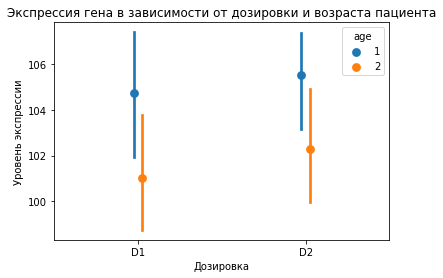

In [171]:
pointplot = sns.pointplot(x=data.dose, y=data.expr, hue=data.age, data=data, dodge=True, linestyles=['', ''])
pointplot.axes.set_title("Экспрессия гена в зависимости от дозировки и возраста пациента", fontsize=12)
pointplot.set_xlabel("Дозировка", fontsize=10)
pointplot.set_ylabel("Уровень экспрессии", fontsize=10)

Большая часть изменчивости обуславливается благодаря фактору - "Возраст", а фактор "Дозировка", "Взаимодействие факторов между собой", "Внутригрупповая изменчивость" оказались не столь значительными. 

#### Вывод: статистически значимый эффект для фактора возраста пациентов (p < 0.05, f = 7.4). Т.е. возраст значительно влияет на уровень экпрессии.